# core

> Fill in a module description here

In [ ]:
#| default_exp core

First, we evaluate how the datasets are loaded by the `nonlinear_benchmarks` library

In [ ]:
#| export
from nonlinear_benchmarks import *
from pathlib import Path
import numpy as np
import h5py
from fastcore.test import *
import os

In [ ]:
#| hide
import shutil
import matplotlib.pyplot as plt

## workshop utilities

nonlinear_benchmarks.utilities.Input_output_data

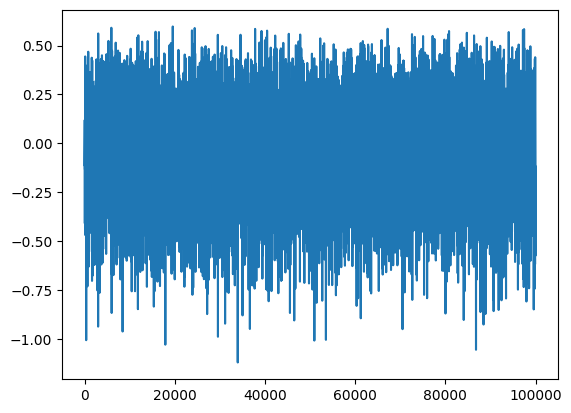

In [ ]:
train_val, test = nonlinear_benchmarks.WienerHammerBenchMark()
plt.plot(train_val.y)
type(train_val)

In [ ]:
train_val??

Type:        Input_output_data
String form: Input_output_data "train WH" u.shape=(100000,) y.shape=(100000,) sampling_time=1.953e-05
Length:      100000
File:        c:\users\danie\miniconda3\envs\sysbench\lib\site-packages\nonlinear_benchmarks\utilities.py
Source:     
class Input_output_data:
    def __init__(self, u, y, sampling_time=None, name=None, state_initialization_window_length=None):
        assert len(u)==len(y), f'input sequence u need to have the same length as y: currently {u.shape=}, {y.shape=}'
        self.u = u
        self.y = y
        self.sampling_time = sampling_time
        self.name = '' if name is None else name
        self.state_initialization_window_length = state_initialization_window_length
    
    def __repr__(self):
        z = '' if (self.name==None or self.name=='') else f' "{self.name}"' 
        u, y = self.u, self.y
        A = f'sampling_time={float(self.sampling_time):.4}' if isinstance(self.sampling_time, Number) else 'sampling_time=Discrete t

The data is store in a `Input_output_data` class, which provides customized access. We want to write a function, which exports the underlying data to hdf5 files.

In [ ]:
u = train_val.atleast_2d().u
u.shape

(100000, 1)

In [ ]:
#| export
def write_dataset(group, #opened hdf5 group to write the dataset, can be a file or group
         ds_name:str, #name of the new dataset
         data: np.array, #data to write to the dataset
         dtype='f4', #datatype, the data will be converted to
         chunks=None #chunking of the hdf5 file, enables faster reading and writing of small parts
         ):
    group.create_dataset(ds_name, data=data, dtype=dtype, chunks=chunks)

In [ ]:
tmp_dir = Path('./tmp/')
os.makedirs(tmp_dir,exist_ok=True)
tmp_file = tmp_dir / 'tmp.hdf5'
with h5py.File(tmp_file,'w') as f:
    write_dataset(f,'u',u)

with h5py.File(tmp_file,'r') as f:
    hdf_u = f['u'][:]
    test_ne(hdf_u.dtype,u.dtype)
    test_eq(hdf_u,u.astype('f4'))

In [ ]:
#| export
def write_array(group, #opened hdf5 group to write the dataset, can be a file or group
                ds_name:str, #name of the new dataset
                data: np.array, #data to write to the dataset
                dtype='f4', #datatype, the data will be converted to
                chunks=None #chunking of the hdf5 file, enables faster reading and writing of small parts
                ) -> None:
    'Writes a 2d numpy array rowwise to a hdf5 file.'
    for i in range(data.shape[1]):
        write_dataset(group, f'{ds_name}{i}', data[:,i], dtype, chunks)

In [ ]:
with h5py.File(tmp_file,'w') as f:
    write_array(f,'u',u)

with h5py.File(tmp_file,'r') as f:
    hdf_u = f['u0'][:]
    test_ne(hdf_u.dtype,u.dtype)
    test_ne(hdf_u,u.astype('f4'))
    test_eq(hdf_u[:,None],u.astype('f4'))

In [ ]:
#| export
def iodata_to_hdf5(iodata:Input_output_data, # data to save to file
            hdf_dir:Path, # Export directory for hdf5 files
            f_name:str = None # name of hdf5 file without '.hdf5' ending
            ):
    data_2d = iodata.atleast_2d()
    u,y = data_2d.u, data_2d.y
    
    os.makedirs(hdf_dir,exist_ok=True)
    if f_name is None: f_name = iodata.name
    
    hdf_path = Path(hdf_dir) / f'{f_name}.hdf5'.replace(" ", "_")
    with h5py.File(hdf_path,'w') as f:
        write_array(f,'u',u)
        write_array(f,'y',y)

    return hdf_path 


In [ ]:
fname = iodata_to_hdf5(train_val,tmp_dir)

with h5py.File(fname,'r') as f:
    hdf_u = f['u0'][:]
    hdf_y = f['y0'][:]
    test_eq(hdf_u[:,None],train_val.atleast_2d().u.astype('f4'))
    test_eq(hdf_y[:,None],train_val.atleast_2d().y.astype('f4'))

Let us evaluate how the general shape of the downloaded datasets looks like

In [ ]:
for bench in nonlinear_benchmarks.all_splitted_benchmarks:
    train,test = bench(atleast_2d=True,always_return_tuples_of_datasets=True)
    print(type(train))
    print(type(train[0]))

<class 'tuple'>
<class 'nonlinear_benchmarks.utilities.Input_output_data'>
<class 'tuple'>
<class 'nonlinear_benchmarks.utilities.Input_output_data'>
<class 'tuple'>
<class 'nonlinear_benchmarks.utilities.Input_output_data'>
<class 'tuple'>
<class 'nonlinear_benchmarks.utilities.Input_output_data'>
<class 'tuple'>
<class 'nonlinear_benchmarks.utilities.Input_output_data'>


With the correct flags set, all datasets have a consistent training and test tuple of one or more elements of type `Input_output_data`. We will transform that in a training, validation and test tuple, which we will then save with a single function.

In [ ]:
# for bench in nonlinear_benchmarks.all_not_splitted_benchmarks:
#     train = bench()
#     if len(train) == 2:
#         train, test = train
#         # print('\n'.join(map(str,train)))
#         if isinstance(train,list):
#             print(len(train))
#             print(train[0].name)

Only the datasets in `nonlinear_benchmarks.all_splitted_benchmarks` have a consistent output form. The other benchmarks have random splits

In [ ]:
#| export
def dataset_to_hdf5(train:tuple, #tuple of Input_output_data for training
                    valid:tuple,#tuple of Input_output_data for validation
                    test:tuple,#tuple of Input_output_data for test
                    save_path: Path #directory the files are written to, created if it does not exist
                    ):
    'Save a dataset consisting of training, validation, and test set in hdf5 format in seperate subdirectories'

    dict_data = {'train':train,
                 'valid':valid,
                 'test':test}
    for subset,ds_entries in dict_data.items():
        if isinstance(ds_entries,tuple):
            if not isinstance(ds_entries[0],Input_output_data): raise ValueError(f'Data has to be stored in tuples of Input_output_data. Got {type(ds_entries[0])}')
        else:
            if not isinstance(ds_entries,Input_output_data): raise ValueError(f'Data has to be stored in Input_output_data. Got {type(ds_entries)}')
            dict_data[subset] = (ds_entries,)

    os.makedirs(save_path,exist_ok=True)

    for subset,ds_entries in dict_data.items():
        for idx,iodata in enumerate(ds_entries):
            iodata_to_hdf5(iodata,save_path / subset,f'{subset}_{idx}')

In [ ]:
train_val, test = nonlinear_benchmarks.WienerHammerBenchMark()
split_idx = 90_000
train = train_val[:split_idx]
valid = train_val[split_idx:]
test = test

In [ ]:
dataset_to_hdf5(train,valid,test,tmp_dir)
dataset_to_hdf5((train,),valid,test,tmp_dir)

## Download Utilities

In [ ]:
#| export
import requests,io,os
import zipfile,rarfile

In [ ]:
#| export
def unzip_download(url:str, #url to file to download
                   extract_dir = '.' #directory the archive is extracted to
                   ):
    'downloads a zip archive to ram and extracts it'
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_dir)

In [ ]:
#| export
def unrar_download(url:str, #url to file to download
                   extract_dir = '.' #directory the archive is extracted to
                   ):
    'downloads a rar archive to ram and extracts it'
    response = requests.get(url)
    with rarfile.RarFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_dir)

In [ ]:
#| export
def download(url:str, #url to file to download
             target_dir = '.'
             ):
    fname = Path(url).name
    if os.path.isfile(fname): return
    response = requests.get(url)
    p_name = Path(target_dir).joinpath(fname)
    with open(p_name, "wb") as file:
        file.write(response.content)
    return p_name

In [ ]:
#| hide
#clean temporary hdf5 file
# shutil.rmtree(tmp_dir)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()